# Customizing Requests

This document walks through the process of customizing Trajectory POST requests to [Contrails API](https://api.contrails.org). In particular, both **aircraft performance** input (fuel flow, engine efficiency, aircraft mass) and **meteorology** data may be optionally included in the request body as a way to specialize the underlying model computed in the backend. Here, we show the process of customizing requests to the `/trajectory/sac` and `/trajectory/cocip` endpoints.

See [Customizable Fields](#Customizable-Fields) for a full summary.

See [Get Started](https://apidocs.contrails.org/notebooks/get_started.html) to get oriented with the following topics.

- Authorization
- Key Validation
- Trajectory API

## Setup

Ensure you have a valid auth key configured.

In [1]:
import os

import matplotlib.pyplot as plt  # pip install matplotlib
import numpy as np  # pip install numpy
import pandas as pd  # pip install pandas
import requests  # pip install requests

In [2]:
# Define credentials
URL = "https://api.contrails.org"
API_KEY = os.environ["CONTRAILS_API_KEY"]  # put in your API key here
HEADERS = {"x-api-key": API_KEY}

### Create flight

Requests to `/trajectory` endpoints are performed via POST, with a JSON flight object in the body. A minimal flight requires four temporal-spatial fields and an [ICAO aircraft type](https://www.icao.int/publications/DOC8643/Pages/Search.aspx): `time`, `longitude`, `latitude`, `altitude`, and `aircraft_type`. If aircraft performance variables are not supplied in the request body, they are computed in API backend. Similarly, if meteorology data is not supplied in the request body, the flight is interpolated against a gridded weather product (either ECMWF ERA5 or ECMWF HRES depending on time field of the flight).

Below we prepare a request by constructing a synthetic flight object for the POST body. This is the same approach taken in [Get Started](https://apidocs.contrails.org/notebooks/get_started.html).

In [3]:
n_waypoints = 200
t0 = "2022-12-28T07:30:00"
t1 = "2022-12-28T11:00:00"

flight = {
    "longitude": np.linspace(-29, -50, n_waypoints).tolist(),
    "latitude": np.linspace(45, 42, n_waypoints).tolist(),
    "altitude": np.linspace(36000, 30000, n_waypoints).tolist(),
    "time": pd.date_range(t0, t1, periods=n_waypoints).astype(int).tolist(),
    "aircraft_type": "A320",
}

## Custom requests to the `/trajectory/sac` endpoint

We explore the Schmidt Appleman criterion (SAC) along a flight trajectory.

### A minimal request to the `/trajectory/sac` endpoint

The `flight` dictionary already contains all of the required fields to make a POST request.

In [4]:
r = requests.post(f"{URL}/v0/trajectory/sac", json=flight, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}\n")

r_json = r.json()
for k, v in r_json.items():
    print(f"{k}: {v}")

HTTP Response Code: 200 OK

flight_id: 1732208959759237
met_source_provider: ECMWF
met_source_dataset: ERA5
met_source_product: reanalysis
pycontrails_version: 0.52.1
humidity_scaling_name: histogram_matching
humidity_scaling_formula: era5_quantiles -> iagos_quantiles
engine_efficiency: [0.281, 0.281, 0.281, 0.281, 0.281, 0.281, 0.281, 0.281, 0.281, 0.281, 0.281, 0.281, 0.281, 0.281, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.277, 0.277, 0.277, 0.277, 0.277, 0.277, 0.277, 0.277, 0.277, 0.277, 0.276, 0.276, 0.276, 0.276, 0.276, 0.276, 0.276, 0.276, 0.276, 0.276, 0.276, 0.276, 0.276, 0.276, 0.275, 0.275, 0.275, 0.275, 0.275, 0.274, 0.274, 0.274, 0.274, 0.274, 0.274, 0.273, 0.273, 0.273,

#### Interpret the Response

The response includes some descriptive information, an array of computed `engine_efficiency` values, and the primary output: an `sac` array indicating whether conditions are present at each flight waypoint for initial contrail formation.

The plot below shows SAC values along the simulated flight trajectory. Values of 1 indicate criteria for contrail formation (the SAC is satisfied). Values of 0 indicate no initial contrail formation (the SAC fails).

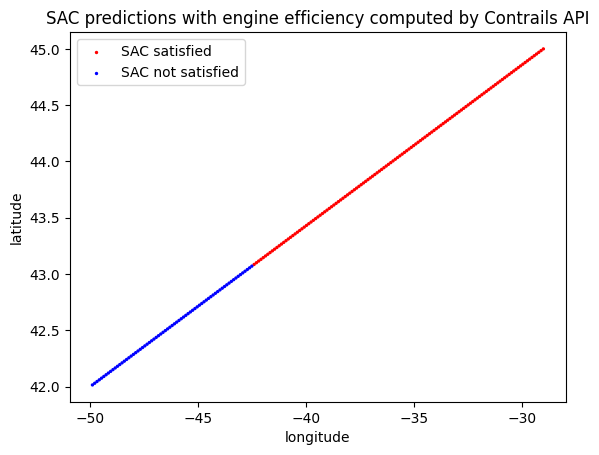

In [5]:
flight_df = pd.DataFrame(flight).assign(sac=r_json["sac"])
flight_df["time"] = pd.to_datetime(flight_df["time"])

fig, ax = plt.subplots()
flight_df.plot.scatter("longitude", "latitude", c="sac", cmap="bwr", s=2, colorbar=False, ax=ax)
ax.set_title("SAC predictions with engine efficiency computed by Contrails API")
ax.scatter(None, None, s=2, c="r", label="SAC satisfied")
ax.scatter(None, None, s=2, c="b", label="SAC not satisfied")
ax.legend();

### Backend-computed engine efficiency

The Schmidt-Appleman criterion [requires engine efficiency as a model input](https://elib.dlr.de/32128/1/mz-96.pdf). In order to handle requests such as the previous example in which no `engine_efficiency` is provided, the API derives it from an aircraft performance model. If calculated while fulfilling the request, `engine_efficiency` is also included in the response.

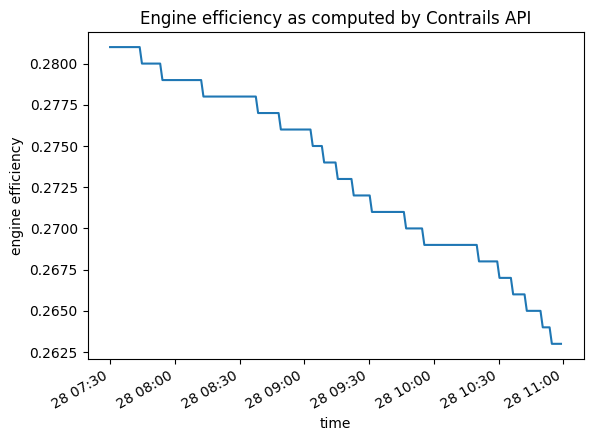

In [6]:
flight_df = flight_df.assign(eta=r_json["engine_efficiency"])
flight_df.plot(
    "time",
    "eta",
    title="Engine efficiency as computed by Contrails API",
    ylabel="engine efficiency",
    legend=False,
);

### Custom engine efficiency

As discussed above, the `/trajectory/sac` endpoint relies on an aircraft performance model when `engine_efficiency` is not provided in request. When making requests that trigger the aircraft performance model, additional inputs such as `aircraft_mass`, `fuel_flow`, and `thrust` can be provided with the request. Here, we provide `aircraft_mass` values in the request body. This will be picked up and used in the backend aircraft performance model to compute fuel flow.

In [7]:
flight_custom = {**flight, "aircraft_mass": np.linspace(72600, 64350, n_waypoints).tolist()}

r = requests.post(f"{URL}/v0/trajectory/sac", json=flight_custom, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}\n")

r_json_custom = r.json()
for k, v in r_json_custom.items():
    print(f"{k}: {v}")

HTTP Response Code: 200 OK

flight_id: 1732208971994476
met_source_provider: ECMWF
met_source_dataset: ERA5
met_source_product: reanalysis
pycontrails_version: 0.52.1
humidity_scaling_name: histogram_matching
humidity_scaling_formula: era5_quantiles -> iagos_quantiles
engine_efficiency: [0.279, 0.279, 0.279, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279, 0.278, 0.278, 0.278, 0.278, 0.278, 0.278, 0.277, 0.277, 0.277, 0.277, 0.277, 0.277, 0.277, 0.277, 0.276, 0.276, 0.276, 0.276, 0.276, 0.27

#### Compare the responses

As shown below, supplying a custom aircraft mass gives rise to different engine efficiency and therefore different SAC predictions.

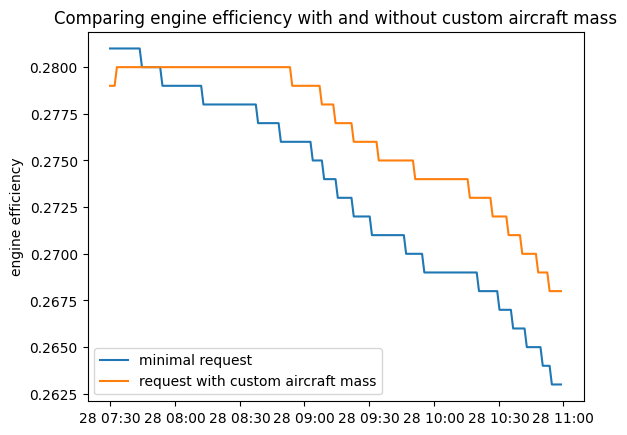

In [8]:
fig, ax = plt.subplots()
ax.plot(flight_df["time"], r_json["engine_efficiency"], label="minimal request")
ax.plot(
    flight_df["time"],
    r_json_custom["engine_efficiency"],
    label="request with custom aircraft mass",
)
ax.set_ylabel("engine efficiency")
ax.set_title("Comparing engine efficiency with and without custom aircraft mass")
ax.legend();

### Bypass Contrails API's aircraft performance model

Engine efficiency can itself be provided directly with the request, in which case the aircraft performance model is not used in the backend. For the SAC model, any additional `aircraft_mass`, `fuel_flow`, and `thrust` are not used (they are only used as *inputs* to the aircraft performance model).

Here, we provide `engine_efficiency` with the request, using values that are 80% of those computed by and returned in the first request.

> Note: Currently, `engine_efficiency` values returned by the API have an undefined value at the terminal trajectory waypoint. In the cell below, we forward fill the `engine_efficiency` at the last waypoint.

In [9]:
eta = [0.8 * e for e in r_json["engine_efficiency"][:-1]]
eta.append(eta[-1])  # fill the nan value
flight_custom = {**flight, "engine_efficiency": eta}

r = requests.post(f"{URL}/v0/trajectory/sac", json=flight_custom, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
r_json_custom = r.json()

HTTP Response Code: 200 OK


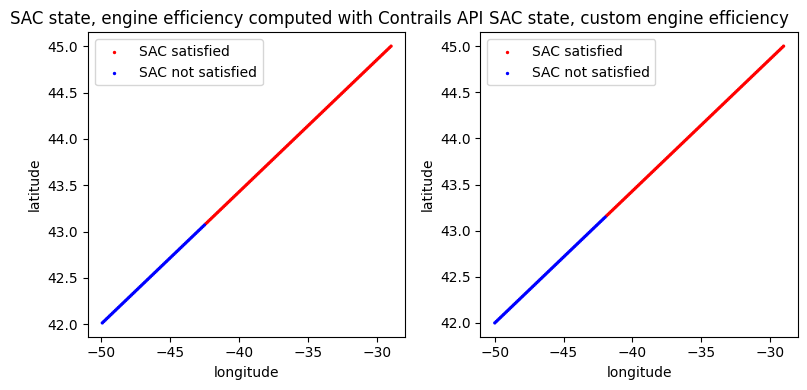

In [10]:
flight_df_custom = pd.DataFrame(flight_custom).assign(sac=r_json_custom["sac"])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
flight_df.plot.scatter("longitude", "latitude", s=2, c="sac", cmap="bwr", ax=ax1, colorbar=False)
flight_df_custom.plot.scatter(
    "longitude", "latitude", s=2, c="sac", cmap="bwr", ax=ax2, colorbar=False
)

ax1.set_title("SAC state, engine efficiency computed with Contrails API")
ax2.set_title("SAC state, custom engine efficiency")

for ax in [ax1, ax2]:
    ax.scatter(None, None, s=2, c="r", label="SAC satisfied")
    ax.scatter(None, None, s=2, c="b", label="SAC not satisfied")
    ax.legend()
plt.tight_layout();

> Note the higher incidence of initial contrails associated with higher engine efficiency values. This is expected.

### Custom meteorology

Meteorological conditions used to calculate SAC are derived from ECMWF ERA5 data. Custom meteorology can be provided with the requests. Meteorology fields include `air_temperature` and `specific_humidity`. See [Customizable Fields](#Customizable-Fields) for more details.

Here, we include custom specific humidity data in the request and compare the results.

HTTP Response Code: 200 OK


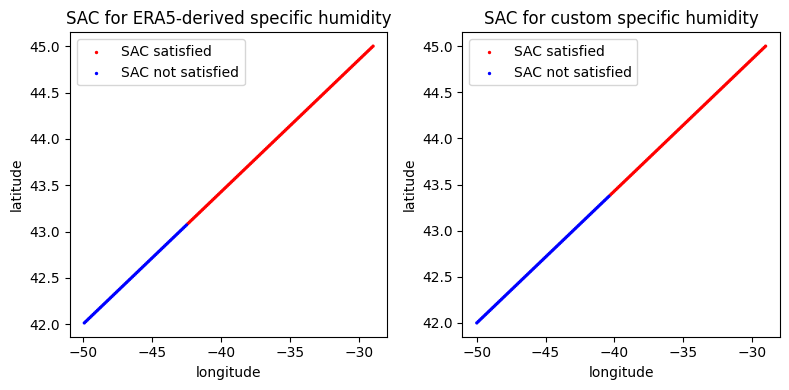

In [11]:
q = np.linspace(0.0000067, 0.0001148, n_waypoints).tolist()
flight_humid = {**flight_custom, "specific_humidity": q}

r = requests.post(f"{URL}/v0/trajectory/sac", json=flight_humid, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
r_json_humid = r.json()

flight_df_humid = pd.DataFrame(flight_humid).assign(sac=r_json_humid["sac"])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
flight_df.plot.scatter("longitude", "latitude", s=2, c="sac", cmap="bwr", ax=ax1, colorbar=False)
flight_df_humid.plot.scatter(
    "longitude", "latitude", s=2, c="sac", cmap="bwr", ax=ax2, colorbar=False
)
ax1.set_title("SAC for ERA5-derived specific humidity")
ax2.set_title("SAC for custom specific humidity")

for ax in [ax1, ax2]:
    ax.scatter(None, None, s=2, c="r", label="SAC satisfied")
    ax.scatter(None, None, s=2, c="b", label="SAC not satisfied")
    ax.legend()

plt.tight_layout();

## Custom requests to the `/trajectory/cocip` endpoint

We make five separate requests to the `/trajectory/cocip` endpoint, each with different custom aircraft performance data.

> [Fleet computation](https://apidocs.contrails.org/notebooks/fleet_mode.html) is not currently equipped to handle flight data with different input fields. Consequently, we make five separate requests to `/trajectory/cocip` instead of a single fleet request.

### Engine specialization

The `engine_uid` field is used to query the [ICAO Aircraft Engine Emissions Databank](https://www.easa.europa.eu/en/domains/environment/icao-aircraft-engine-emissions-databank). If known, it should be provided with the request. If not, the API will attempt to match the `aircraft_type` to an engine in the databank. See the [Default Engine Table](https://apidocs.contrails.org/engines.html) for a default mapping of aircraft types to engines.

In [12]:
r = requests.post(f"{URL}/v0/trajectory/cocip", json=flight, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
r_json_no_customization = r.json()

HTTP Response Code: 200 OK


In [13]:
payload = {**flight, "engine_efficiency": np.linspace(0.35, 0.31, n_waypoints).tolist()}
r = requests.post(f"{URL}/v0/trajectory/cocip", json=payload, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
r_json_custom_ee = r.json()

HTTP Response Code: 200 OK


In [14]:
payload = {**flight, "thrust": np.linspace(25000, 30000, n_waypoints).tolist()}
r = requests.post(f"{URL}/v0/trajectory/cocip", json=payload, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
r_json_custom_thrust = r.json()

HTTP Response Code: 200 OK


In [15]:
payload = {**flight, "fuel_flow": 0.65}  # use a scalar value for the entire trajectory
r = requests.post(f"{URL}/v0/trajectory/cocip", json=payload, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
r_json_custom_ff = r.json()

HTTP Response Code: 200 OK


In [16]:
payload = {**flight, "engine_uid": "01P10IA019"}  # override the assumed engine UID
r = requests.post(f"{URL}/v0/trajectory/cocip", json=payload, headers=HEADERS)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
r_json_custom_engine = r.json()

HTTP Response Code: 200 OK


### Visualize responses

Providing custom aircraft performance data does change CoCiP model output. Below we plot contrail age and energy forcing predictions.

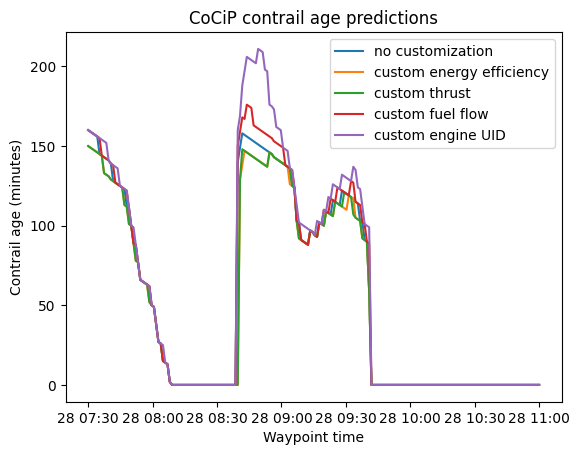

In [17]:
fig, ax = plt.subplots()
ax.plot(flight_df["time"], r_json_no_customization["contrail_age"], label="no customization")
ax.plot(flight_df["time"], r_json_custom_ee["contrail_age"], label="custom energy efficiency")
ax.plot(flight_df["time"], r_json_custom_thrust["contrail_age"], label="custom thrust")
ax.plot(flight_df["time"], r_json_custom_ff["contrail_age"], label="custom fuel flow")
ax.plot(flight_df["time"], r_json_custom_engine["contrail_age"], label="custom engine UID")
ax.legend()
ax.set_title("CoCiP contrail age predictions")
ax.set_ylabel("Contrail age (minutes)")
ax.set_xlabel("Waypoint time");

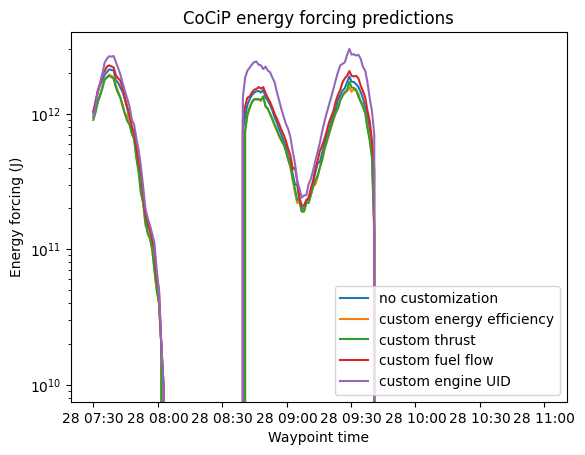

In [18]:
fig, ax = plt.subplots()
ax.plot(flight_df["time"], r_json_no_customization["energy_forcing"], label="no customization")
ax.plot(flight_df["time"], r_json_custom_ee["energy_forcing"], label="custom energy efficiency")
ax.plot(flight_df["time"], r_json_custom_thrust["energy_forcing"], label="custom thrust")
ax.plot(flight_df["time"], r_json_custom_ff["energy_forcing"], label="custom fuel flow")
ax.plot(flight_df["time"], r_json_custom_engine["energy_forcing"], label="custom engine UID")
ax.legend()
ax.set_title("CoCiP energy forcing predictions")
ax.set_ylabel("Energy forcing (J)")
ax.set_yscale("log")
ax.set_xlabel("Waypoint time");

## Customizable Fields

If known, the `engine_uid` should be provided with the request. See our [table of default values](https://apidocs.contrails.org/engines.html) for a mapping of aircraft types to engines.

A table of additional customizable fields is shown below. See [Contrails API Schemas](https://api.contrails.org/openapi) for details on each the aircraft performance fields, including descriptions and units of measure.

|`/trajectory` endpoint | Aircraft performance fields | Meteorology fields |
|-|-|-|
| `/sac`   | `true_airspeed`\*, `fuel_flow`\*, `thrust`\*, `aircraft_mass`\*, `engine_efficiency` | `air_temperature`, `specific_humidity` |
| `/issr` | (none) | `air_temperature`, `specific_humidity` |
| `/pcr` | (same as `/sac`) | (same as `/sac`) |
| `/emissions` | (same as `/sac`) | (same as `/sac`) |
| `/cocip` | `true_airspeed`, `fuel_flow`, `thrust`\*, `aircraft_mass`, `engine_efficiency`, `nvpm_ei_n`, `wingspan` | `air_temperature`\*\*, `specific_humidity`\*\*, `u_wind`\*\*, `v_wind`\*\* |
| `/cocip-contrail` | (same as `/cocip`) | (same as `/cocip`) |


<sup>*</sup> Unused if `engine_efficiency` is also provided

<sup>**</sup> Currently, met can only be customized on first step of CoCiP

## Best practices

- If any aircraft performance is known along a flight trajectory, it should be supplied with the `/trajectory` request for more precise predictions.
- If meterology is known along a flight trajectory, it can be supplied with the `/trajectory` request. The CoCiP model employs an iterative contrail evolution. Consequently, the `/trajectory/cocip` endpoint will only use custom meteorology data in the initial step. Customizing meteorology should be consider experimental.